In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize

In [4]:
# this notebook is to test that everything in center fed mode works as expected
num_straps = 9
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(81,112, 1)
capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'
antfile = 'circ_model/fixed_bigscan_full_CF.csv' 
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile, center_fed_mode=True)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
num_straps:     9
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


In [7]:
# Testing out the differential evolution optimization method 
# confirm class version works 

bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92, 100)
s11cutoff = -45

# res = myrfTWA.run_differential_evolution_global_op(bounds,
#                                             S11_db_cutouff=s11cutoff,
#                                             freq_bounds=freq_bounds,
#                                             strategy='best1bin',
#                                             symetric_mode=True,
#                                             one_cap_type_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.05932584 0.11832334 0.1134162  0.11396382 0.06137723]
Average absolute error is : 1.79e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.11539493 0.14070589 0.05133372 0.09630993 0.15263734]
Average absolute error is : 1.80e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.15076492 0.12016615 0.06347704 0.11779875 0.12570748]
Average absolute error is : 1.73e+04
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.08996985 0.12561356 0.10038504 0.07798586 0.10098251]
Average absolute error is : 1.62e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.11240227 0.07062383 0.11378739 0.12969413 0.12425651]
Average absolute error is : 1.51e+04
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.1106876  0.0779367  0.14637215 0.15086578 0.08925875]
Avera

final lengths: [0.12044063346917347, 0.0800760559464497, 0.05956953848103621, 0.061853101590082525, 0.09956078820318268]


C:\Users\jacob\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


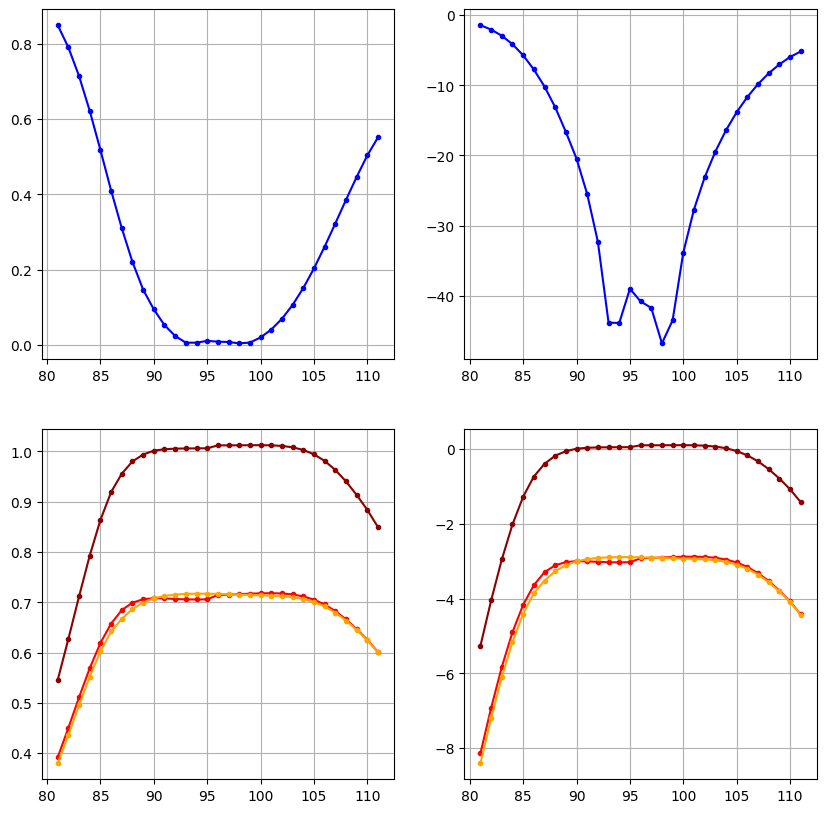

In [12]:
lengths_found = res.x.tolist()
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

In [28]:
#lengths = [0.1311778221225474, 0.11519046885602385, 0.14010718256369714, 0.12735421956841164, 0.1431832918398686] # these are for the < -45 dB, beta = 100, f = 92 to 100
lengths = [0.12810392247316846, 0.11046490960219796, 0.13937978734857429, 0.10464024587092911, 0.05006480615180657]
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths, symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0, 0] # power excitation at the three ports 
phase = [0, 0, 0] # radians 
print('port indicies', full_circ.port_indexes)
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
# print(full_circ.currents(power,phase).shape)
print(full_circ.frequency.f_scaled)
print(full_circ.currents(power,phase)[2,:])
print('--')
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

port indicies [1, 3, 5]
[ 81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111.]
[ 0.05645035-0.09005529j -0.05645035+0.09005529j -0.03235786-0.09427429j
  0.03235786+0.09427429j -0.03028943-0.09246663j  0.03028943+0.09246663j
  0.11081266+0.05622058j -0.11081266-0.05622058j  0.0356714 +0.1813066j
 -0.0356714 -0.1813066j  -0.08176254+0.14482913j  0.08176254-0.14482913j
 -0.03814916-0.15288488j  0.03814916+0.15288488j  0.01003804-0.11522379j
 -0.01003804+0.11522379j -0.03622889-0.15141109j  0.03622889+0.15141109j
 -0.08198539+0.14374038j  0.08198539-0.14374038j  0.03118984+0.17977025j
 -0.03118984-0.17977025j  0.10740246+0.05639048j -0.10740246-0.05639048j]
--
[ 0.23408643+0.11636876j -0.15358029+0.30978733j -0.22764511-0.26446351j
  0.35036313-0.02786288j  0.04954454+0.0754482j   0.35044738-0.04906416j
 -0.23003194-0.25375033j -0.14622002+0.3164049j   0.23549225+0.10719631j]
[  26.4328

[ 0.14684907  0.64650219 -0.7262291  -0.02526066  0.31504617 -0.04427698
 -0.73440671  0.63779471  0.13597265]


Text(0, 0.5, 'P(n||) [arb]')

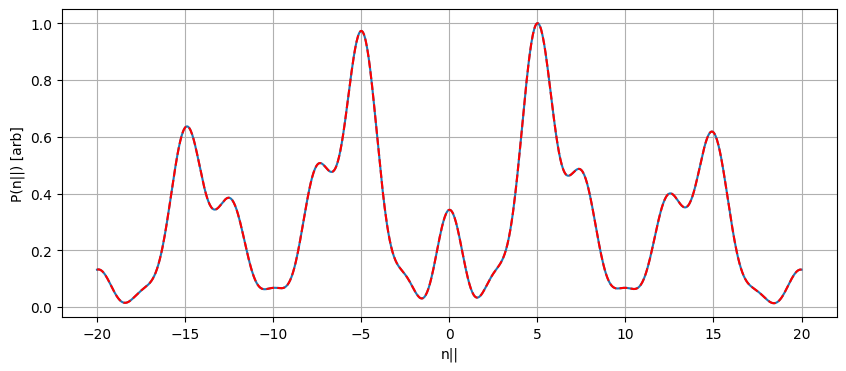

In [29]:
npar_array = np.linspace(-20, 20, 1000)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)))


# try adjusting phases by a constant 

strap_phases2 = strap_phases #+ np.array([40, 60, 20, 25, 3, 45, 180, 8, 12]) * (np.pi/180)
result2 = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases2)
    result2 = np.append(result2, power)

plt.plot(npar_array, np.real(result2)/np.max(np.real(result2)), color='red', linestyle='--')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

[  38.76533735  -57.52564163 -179.03263026   54.55775664  -74.88705166
  156.8699224    31.06947552  -92.07114936  173.17510261]
d:  0.15625
wstrap:  0.08


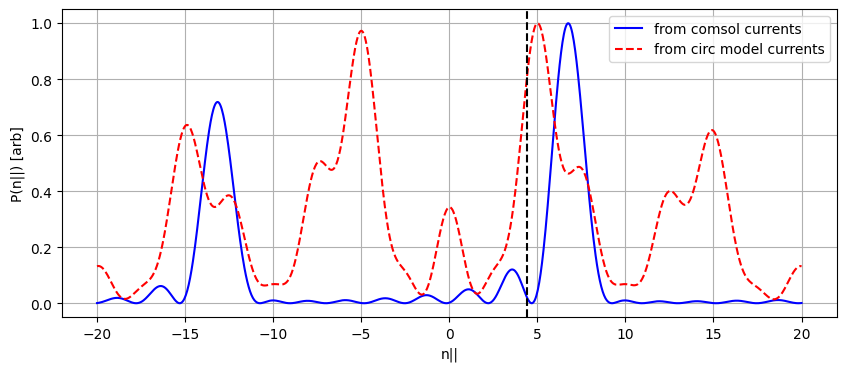

In [30]:
cap_currents = np.array([0.0031801+0.0025537*1j, 0.0029809-0.0046837*1j, -0.0056296-9.5058E-5*1j, 0.0038771+0.0054471*1j, 0.0015648-0.0057942*1j, -0.0060589+0.0025881*1j, 0.0048643+0.0029308*1j, -2.0236E-4-0.0055956*1j, -0.0040003+4.7877E-4*1j])
cap_phases = get_phase(cap_currents)
print(cap_phases*180/np.pi)
print('d: ', myrfTWA.geometry_dict['d'])
print('wstrap: ', myrfTWA.geometry_dict['wstrap'])
npar_array = np.linspace(-20, 20, 1000)

result = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=0.085,
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=cap_phases)
    result = np.append(result, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='blue', label='from comsol currents')
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='from circ model currents')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=4.384384384384383, ymin=0, ymax=1, color='k', linestyle='--')

In [31]:
# Now, test out the new optimizer 
bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92, 100)
s11cutoff = -45

# new settings 
alpha = 80000 # 10,000 worked well 
target_npar = 5
npar_bounds = [0, 10]
num_npars = 100


res = myrfTWA.run_differential_evolution_global_op_npar_match( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            target_npar=5,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.11144006 0.13033485 0.06810414 0.08641096 0.07690168]


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'